In [ ]:
pip install tensorflow
pip install requests
pip install pandas
pip install matplotlib
pip install torch
pip install plotly

In [ ]:
pip install torch

In [1]:
def merge_json_objects(obj1, obj2):
    merged_data = {}

    #add ojb1 into holding dict. if key is found in both, merge them then add
    for key, value in obj1.items():
        if key in obj2:
            merged_data[key] = value+obj2[key]
        else:
            merged_data[key] = value

    #add obj2 into holding dict only if key not in obj1
    for key, value in obj2.items():
        if key not in merged_data:
            merged_data[key] = value
            
    return merged_data

In [2]:
def get_stock_data(url, next_page_token=None):
    # Make a request to the stock price endpoint
    apiKey = 'PKVVMO4VIR8019Z87DV6'
    apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf'
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": apiKey,
        "APCA-API-SECRET-KEY": apiSecret
    }
    response = requests.get(url+next_page_token, headers=headers)
    
    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        bars = json_data['bars']
        # Extract stock data from the current page
        current_page_data = {key: bars[key] for key in bars.keys()}
        # Check if there is a next page
        next_page_token = json_data.get('next_page_token')
        if next_page_token is not None:
            # Recursively fetch and merge the next page data
            next_page_data = get_stock_data(url, '&page_token='+next_page_token)
            current_page_data = merge_json_objects(current_page_data, next_page_data)

        return current_page_data

    else:
        # Handle the case where the API request was not successful
        print(f"Error: {response.status_code}")
        return None


In [ ]:
def get_stock_data(url, next_page_token=None):
    # Make a request to the stock price endpoint
    apiKey = 'PKVVMO4VIR8019Z87DV6'
    apiSecret = 'XlEHA9LpAe3lCmbASJY1Ffze3aRhmCdkhvM1SBnf'
    headers = {
        "accept": "application/json",
        "APCA-API-KEY-ID": apiKey,
        "APCA-API-SECRET-KEY": apiSecret
    }
    response = requests.get(url+next_page_token, headers=headers)
    
    # Check if the response is successful
    if response.status_code == 200:
        # Parse the JSON response
        json_data = response.json()
        bars = json_data['bars']
        # Extract stock data from the current page
        current_page_data = {key: bars[key] for key in bars.keys()}
        # Check if there is a next page
        next_page_token = json_data.get('next_page_token')
        if next_page_token is not None:
            # Recursively fetch and merge the next page data
            next_page_data = get_stock_data(url, '&page_token='+next_page_token)
            current_page_data = merge_json_objects(current_page_data, next_page_data)

        return current_page_data

    else:
        # Handle the case where the API request was not successful
        print(f"Error: {response.status_code}")
        return None


In [3]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np

#gets stock data and cleans it
def stock_data(symbols, pathParam, queryParams):
    #base url to build off of
    base_url = "https://data.alpaca.markets/v2/stocks/"

    #add specific api path
    base_url += pathParam

    #add stock symbols to url
    base_url += 'symbols='
    for symbol in symbols:
        base_url += symbol + "%2C";
        base_url[:-3]

    #add params to urls
    for key, value in queryParams.items():
        base_url += "&";
        base_url += key;
        base_url += "=";
        base_url += value;

    #get merged price data
    results = get_stock_data(base_url, '')

    #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
    symbols = list(results.keys())
    #create empty dict to hold each symbols data
    tables = {}
    for symbol in symbols:
        #get specific symbol's data
        data = results[symbol]
        
        # Convert timestamp strings to datetime objects
        for point in data:
            #FIXME: make sure every endpoint includes 't' measure
            point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
        
        # Create a Pandas DataFrame
        df = pd.DataFrame(data)
            
            
        # FIXME: This is not needed in prod. Wasted computation. Not agnostic
        df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
        df.set_index('timestamp', inplace= True)
    
        # add df to dictionary of dfs
        tables[symbol] = df

    return tables


In [ ]:
import pandas as pd
import requests
from datetime import datetime
import numpy as np

#gets stock data and cleans it
def crypto_data(symbols, pathParam, queryParams):
    #base url to build off of
    base_url = "https://data.alpaca.markets/v1beta3/crypto/us/"

    #add specific api path
    base_url += pathParam

    #add stock symbols to url
    base_url += 'symbols='
    for symbol in symbols:
        base_url += symbol + "%2C";
        base_url[:-3]

    #add params to urls
    for key, value in queryParams.items():
        base_url += "&";
        base_url += key;
        base_url += "=";
        base_url += value;

    #get merged price data
    results = get_stock_data(base_url, '')

    #create list of symbols. FIXME: this could probably use the symbols param. dont know which is faster
    symbols = list(results.keys())
    #create empty dict to hold each symbols data
    tables = {}
    for symbol in symbols:
        #get specific symbol's data
        data = results[symbol]
        
        # Convert timestamp strings to datetime objects
        for point in data:
            #FIXME: make sure every endpoint includes 't' measure
            point["t"] = datetime.strptime(point["t"], "%Y-%m-%dT%H:%M:%SZ")
        
        # Create a Pandas DataFrame
        df = pd.DataFrame(data)
            
            
        # FIXME: This is not needed in prod. Wasted computation. Not agnostic
        df.rename(columns={'c': 'close', 'h':'high', 'l':'low', 'n':'trade_count', 'o':'open', 't':'timestamp', 'v':'bar_volume', 'vw':'price_volume_weighted'}, inplace=True)
        df.set_index('timestamp', inplace= True)
    
        # add df to dictionary of dfs
        tables[symbol] = df

    return tables


In [4]:
def create_MACD(data, config):
    shortPeriod = config['shortPeriod']
    longPeriod = config['longPeriod']
    signalPeriod = config['signalPeriod']

    #Calculate short and long ewma used to calculate the final macd
    macdShort=pd.Series(data['open'].ewm(span=shortPeriod, min_periods=1, adjust=False).mean())
    macdLong=pd.Series(data['open'].ewm(span=longPeriod, min_periods=1, adjust=False).mean())
    macd = pd.Series(macdShort - macdLong, name='MACD')
    signal = pd.Series(macd.ewm(span=signalPeriod, min_periods=1, adjust=False).mean())
    crossover = macd-signal
    indicator = pd.concat([data, crossover], axis=1)
    return indicator
    

def create_RSI(data, config):
    period = config['period']
    price_change=pd.Series(data['open'].diff())

    # Calculate the average gain and average loss over a x-day period
    gain=pd.Series(price_change.apply(lambda x: x if x > 0 else 0))
    loss=pd.Series(price_change.apply(lambda x: abs(x) if x < 0 else 0))
    avg_gain=pd.Series(gain.rolling(window=period, min_periods=1).mean())
    avg_loss=pd.Series(loss.rolling(window=period, min_periods=1).mean())

    # avg_gain=pd.Series(gain.ewm(span=period, min_periods=1, adjust=False).mean())
    # avg_loss=pd.Series(loss.ewm(span=period, min_periods=1, adjust=False).mean())
        
    # Calculate the relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the RSI
    rsi = pd.Series(100 - (100 / (1 + rs)), name='RSI')
    indicator = pd.concat([data, rsi], axis=1)
    return indicator
    
    
def create_SMA(data, config):
    period = config['period']

    #Calculate simple moving avg
    ma=pd.Series(data['open'].rolling(window=period).mean(), name='SMA')
    indicator=pd.concat([data, ma], axis=1)
    return indicator
    

def create_PriceDelta(data, config):
    period = config['period']

    #Calculate simple price change from previous
    delta=pd.Series(data['open'] - data['open'].shift(period), name='PriceDelta')
    indicator=pd.concat([data, delta], axis=1)
    return indicator


def create_PriceDeltaPercent(data, config):
    period = config['period']
    point = config['point']

    #Calculate simple price change from previous (percent)
    delta=pd.Series(abs(data['open']-data['open'].shift(period)))
    final = pd.Series((delta/data['open'].shift(period))*100, name='value') if point == 'initial' else pd.Series((delta/data['open'])*100, name='PriceDeltaPercent')
    indicator=pd.concat([data, final], axis=1)
    return indicator

def create_EWMA(data, config):
    period = config['period']

    #Calculate ewma
    ewma = pd.Series(data['open'].ewm(span=period, min_periods=1).mean(), name='EWMA')
    indicator=pd.concat([data, ewma], axis=1)
    return indicator

def create_Volume(data, config):
    
    #Calculate volume
    volume = pd.Series(data['bar_volume'], name='Volume')
    indicator=pd.concat([data, volume], axis=1)
    return indicator

#map indicator names to their build functions
indicator_functions = {
    'MACD': create_MACD,
    'RSI': create_RSI,
    'SMA': create_SMA,
    'PriceDelta': create_PriceDelta,
    'PriceDeltaPercent': create_PriceDeltaPercent,
    'EWMA': create_EWMA,
    'Volume': create_Volume
}

In [5]:
def create_features(stock_data, indicator_config):
    features_df = pd.DataFrame()
    features_df.index = stock_data.index

    #fcreate each indicator
    for indicator_name, config in indicator_config.items():
            
        # Use the indicator_functions dictionary to get the appropriate function
        indicator_function = indicator_functions.get(indicator_name)
        if indicator_function:
            
            # Call the selected function with the corresponding configuration
            indicator_value = indicator_function(stock_data, config)
            features_df = features_df.merge(indicator_value[[indicator_name]], left_index=True, right_index=True, how='left')
        else:
            print(f"Warning: Unknown indicator '{indicator}'. Skipping.")
    return features_df

In [6]:
def create_signals(stock_data, signal_memory):
    signal_df = pd.DataFrame()
    signal_df.index = stock_data.index


    #flip list for easier ewma calculation for future prices, with higher weight for more recent prices
    flipped = stock_data['open'][::-1]
    flipped_ewma = flipped.ewm(span=signal_memory, min_periods=0, adjust=False).mean()

    #flip list back
    ewma = flipped_ewma[::-1]

    #signal is simply the change from now to ewma of future x prices
    future_change = ewma - stock_data['open']
    signal = pd.Series(future_change/stock_data['open'], name = 'signal')

    signal_df['signal'] = signal
    
    return signal_df

In [168]:
#main flow
def main(symbols, queryParams, pathParam, indicator_config, signal_memory):
    data = {}

    #get stock data for given symbols
    stock_bars = stock_data(symbols, pathParam, queryParams)

    for symbol, values in stock_bars.items():

        #create master data object and feature df for symbol
        symbol_master = {}
        features_df = pd.DataFrame()

        #create features df
        features_df = create_features(values, indicator_config)

        #create signals df
        signals_df = create_signals(values, signal_memory)

        #get all valid rows
        valid_rows = features_df.notnull().all(axis=1)

        # Filter the DataFrames to include only rows where all columns have data
        features_df = features_df[valid_rows]
        signals_df = signals_df[valid_rows]
        values = values[valid_rows]

        #add frames to master
        symbol_master['features'] = features_df
        symbol_master['signals'] = signals_df
        symbol_master['bars'] = values

        #add master
        data[symbol] = symbol_master

    return data

In [136]:
#init config and get stock price data
symbols = ['F']
queryParams = {
    'timeframe':'3Min',
    'adjustment': 'all',
    'feed': 'sip',
    'sort': 'asc',
    'start': '2016-10-10T00%3A00%3A00Z',
    'limit': '10000'
             }
pathParam = 'bars?'

#Notice: periods are in # measurements, not days
indicator_config = {
    'MACD': {
        'shortPeriod': 120,
        'longPeriod': 240,
        'signalPeriod': 90
    },
    'RSI': {
        'period': 140
    },
    'SMA': {
        'period': 500
    },
    'EWMA': {
        'period': 200
    },
    'Volume': {}
}

data = main(symbols, queryParams, pathParam, indicator_config, signal_memory=3)

In [137]:
# Build net
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns

#define neural net class
class NeuralNetworkv2(nn.Module):
    def __init__(self, input_size, hidden_sizes, dropout_rate, output_size):
        super(NeuralNetworkv2, self).__init__()
        

        #create list of layers
        self.hidden_layers = nn.ModuleList()

        #append input layer to list with dropout
        self.hidden_layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.hidden_layers.append(nn.ReLU())
        self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        #add layers for each size in size list
        for i in range(1, len(hidden_sizes)):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            self.hidden_layers.append(nn.ReLU())
            self.hidden_layers.append(nn.Dropout(p=dropout_rate))

        self.output_layer = nn.Linear(hidden_sizes[-1], output_size)

    
    def forward(self, x):
        for layer in self.hidden_layers:
            x = layer(x)

        # Output layer without activation (for regression)
        output = self.output_layer(x)

        return output

#define neural net class
class NeuralNetworkv1(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetworkv1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

#define lstm class
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.output_size=output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 128)
        self.fc2 = nn.Linear(128, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(self.fc1(hn))  # first Dense
        out = self.relu(self.fc2(out)) 
        return out


def create_model(data, type, model_config):
    num_epochs = model_config['num_epochs']
    learning_rate = model_config['learning_rate']
    input_size = data['features'].shape[1]
    train_size = int(0.8 * len(data['features']))

    #extract features and signals from data object. instantiate scaler objects
    X = data['features']
    y = data['signals']
    mm = MinMaxScaler()
    ss = StandardScaler()

    X_ss = ss.fit_transform(X)
    y_mm = mm.fit_transform(y)
    

    #seperate into training and testing groups
    X_train = X_ss[:train_size, :]
    X_test = X_ss[train_size:, :]
    y_train = y_mm[:train_size, :]
    y_test = y_mm[train_size:, :] 
    
    #turn dfs into tensors
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))
    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 

    #variably create models based on type
    if type == 'LSTM': 
        X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
        X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

        hidden_size = model_config['hidden_size']
        num_layers = model_config['num_layers']
        output_size = 1
        
        model = LSTMNetwork(input_size, hidden_size, num_layers, 1)
        
    # else:
    #     X_train_tensor=torch.FloatTensor(feature_train)
    #     y_train_tensor = torch.FloatTensor(output_train)
        
    #     X_test_tensor = torch.FloatTensor(feature_test)
    #     y_test_tensor = torch.FloatTensor(output_test)

    #     train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    #     model = NeuralNetworkv2(input_size, hidden_sizes, dropout_rate, output_size)

    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

    losses = []
    for epoch in range(num_epochs):
        outputs = model.forward(X_train_tensors_final) #forward pass
        optimizer.zero_grad() #caluclate the gradient, manually setting to 0
     
      # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
     
        loss.backward() #calculates the loss of the loss function
     
        optimizer.step() #improve from loss, i.e backprop
        losses.append(loss.item())
        if epoch % 100 == 0:
            loss_num = loss.item()
            #losses.append(loss_num)
            print("Epoch: %d, loss: %1.5f" % (epoch, loss_num))

    #use previously fitted scalers
    df_X_ss = ss.transform(data['features'])
    df_y_mm = mm.transform(data['signals'])


    #convert to tensors
    df_X_ss = Variable(torch.Tensor(df_X_ss))
    df_y_mm = Variable(torch.Tensor(df_y_mm))
    
    #reshaping the dataset
    df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 
    
    train_predict = model(df_X_ss)#forward pass
    data_predict = train_predict.data.numpy() #numpy conversion
    dataY_plot = df_y_mm.data.numpy()

    #plt.plot(dataY_plot, label='Actual Data')
    
    data_predict = mm.inverse_transform(data_predict) #reverse transformation
    dataY_plot = mm.inverse_transform(dataY_plot)
    training_data = {
        'actual': dataY_plot,
        'predicted': data_predict
    }
    
    return model, losses, training_data

In [138]:
from sklearn.metrics import confusion_matrix

class Model:
    def __init__ (self, model, model_config, training_loss, training_data):
        self.model = model,
        self.model_config = model_config
        self.training_loss = training_loss
        self.training_data = training_data

    def graph_loss(self):
        plt.plot(self.training_loss)
        #plt.title(f'Training Loss Over Time with lr:{self.model_config['learning_rate']}, epoch:{self.model_config['num_epochs']}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.show()

    def graph_confusion(self):
        y_test_np = self.training_data['actual']
        y_pred_np = self.training_data['predicted']
        
        # Apply a threshold if necessary (e.g., for binary classification)
        # For example, if it's a binary classification task:
        threshold = 0.0
        y_pred_binary = (y_pred_np > threshold).astype(int)
        y_test_binary = (y_test_np > threshold).astype(int)
        
        # Create a confusion matrix
        conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
        
        # Display the confusion matrix using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.show()

    def graph_signals(self):
        plt.figure(figsize=(10,6)) #plotting
        plt.axvline(x=train_size, c='r', linestyle='--') #size of the training set
            
        plt.plot(self.training_data['actual'], label='Actual Data') #actual plot
        plt.plot(self.training_data['predicted'], label='Predicted Data') #predicted plot
        plt.title('Time-Series Prediction')
        plt.legend()
        plt.show() 
        
    def graph_prices(self, price_data, point, zoom, mag_scale):
        start_point = int(len(price_data)*point)
        end_point = start_point+zoom
        colors = ['green' if val > 0 else 'red' for val in self.training_data['predicted'][start_point:end_point]]
        magnitudes = [abs(val) for val in self.training_data['predicted'][start_point:end_point]]
        plt.figure(figsize=(10,6)) #plotting            
        plt.scatter(
            y=price_data['open'].iloc[start_point:end_point], 
            x=price_data.iloc[start_point:end_point].index,  
            color=colors, 
            s=[mag_scale * mag for mag in magnitudes])
        plt.title('')
        plt.legend()
        plt.show()



In [167]:
model_config = {
    'num_epochs': 10000,
    'learning_rate': .0001,
    'hidden_size': 2,
    'num_layers': 1
}
model, training_loss, training_data = create_model(data=data['F'], type='LSTM', model_config=model_config)

testModel = Model(model, model_config, training_loss, training_data)

Epoch: 0, loss: 0.18093
Epoch: 100, loss: 0.02802
Epoch: 200, loss: 0.00246
Epoch: 300, loss: 0.00089
Epoch: 400, loss: 0.00072
Epoch: 500, loss: 0.00060
Epoch: 600, loss: 0.00050
Epoch: 700, loss: 0.00042
Epoch: 800, loss: 0.00037
Epoch: 900, loss: 0.00032
Epoch: 1000, loss: 0.00029
Epoch: 1100, loss: 0.00026
Epoch: 1200, loss: 0.00024
Epoch: 1300, loss: 0.00023
Epoch: 1400, loss: 0.00021
Epoch: 1500, loss: 0.00020
Epoch: 1600, loss: 0.00019
Epoch: 1700, loss: 0.00018
Epoch: 1800, loss: 0.00018
Epoch: 1900, loss: 0.00017
Epoch: 2000, loss: 0.00017
Epoch: 2100, loss: 0.00017
Epoch: 2200, loss: 0.00017
Epoch: 2300, loss: 0.00017
Epoch: 2400, loss: 0.00017
Epoch: 2500, loss: 0.00017
Epoch: 2600, loss: 0.00017
Epoch: 2700, loss: 0.00017
Epoch: 2800, loss: 0.00017
Epoch: 2900, loss: 0.00017
Epoch: 3000, loss: 0.00017
Epoch: 3100, loss: 0.00017
Epoch: 3200, loss: 0.00017
Epoch: 3300, loss: 0.00017
Epoch: 3400, loss: 0.00017
Epoch: 3500, loss: 0.00016
Epoch: 3600, loss: 0.00016
Epoch: 3700, 

In [163]:
model_config = {
    'num_epochs': 10000,
    'learning_rate': .0001,
    'hidden_size': 2,
    'num_layers': 1
}
model, training_loss, training_data = create_model(data=data['F'], type='LSTM', model_config=model_config)

testModel = Model(model, model_config, training_loss, training_data)

Epoch: 0, loss: 0.22543
Epoch: 100, loss: 0.20597
Epoch: 200, loss: 0.17316
Epoch: 300, loss: 0.14734
Epoch: 400, loss: 0.12546
Epoch: 500, loss: 0.10664
Epoch: 600, loss: 0.09030
Epoch: 700, loss: 0.07607
Epoch: 800, loss: 0.06371
Epoch: 900, loss: 0.05300
Epoch: 1000, loss: 0.04377
Epoch: 1100, loss: 0.03587
Epoch: 1200, loss: 0.02916
Epoch: 1300, loss: 0.02351
Epoch: 1400, loss: 0.01879
Epoch: 1500, loss: 0.01490
Epoch: 1600, loss: 0.01173
Epoch: 1700, loss: 0.00917
Epoch: 1800, loss: 0.00714
Epoch: 1900, loss: 0.00555
Epoch: 2000, loss: 0.00432
Epoch: 2100, loss: 0.00338
Epoch: 2200, loss: 0.00268
Epoch: 2300, loss: 0.00217
Epoch: 2400, loss: 0.00179
Epoch: 2500, loss: 0.00152
Epoch: 2600, loss: 0.00133
Epoch: 2700, loss: 0.00119
Epoch: 2800, loss: 0.00109
Epoch: 2900, loss: 0.00102
Epoch: 3000, loss: 0.00096
Epoch: 3100, loss: 0.00092
Epoch: 3200, loss: 0.00088
Epoch: 3300, loss: 0.00085
Epoch: 3400, loss: 0.00083
Epoch: 3500, loss: 0.00080
Epoch: 3600, loss: 0.00077
Epoch: 3700, 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


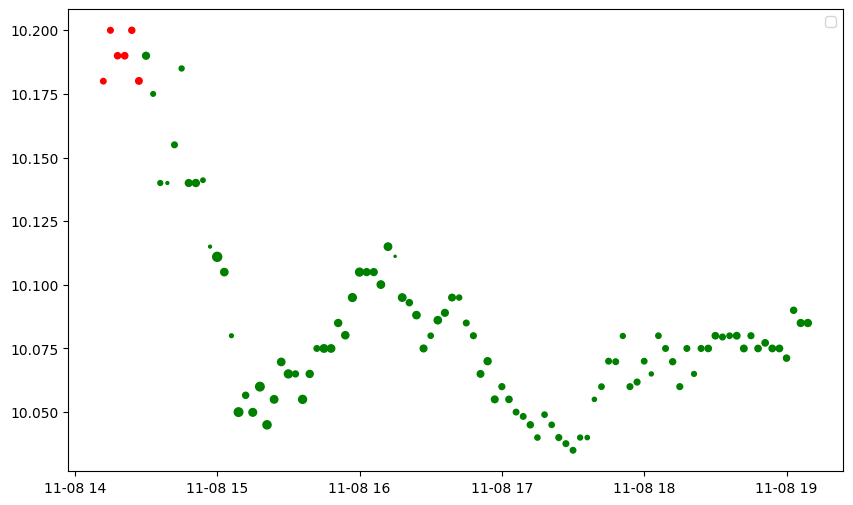

In [214]:
testModel.graph_prices(price_data = data['F']['bars'], point=.97, zoom=100, mag_scale=1000000)

###### testModel.graph_confusion()

In [231]:
def simulate(model, bank_in, trade_size):
    
    predictions = testModel.training_data['predicted']
    actual = testModel.training_data['actual']

    wrong = 0
    right = 0
    count = 0
    bank = bank_in
    trade_size=trade_size
    fiscal_returns = 0
    percent_returns = 0
    for index,  point in enumerate(actual):
        # if index%160==0:
        #     print(bank)
        bank -= trade_size
        if (point*predictions[index]) > 0:
            right += 1
            fiscal_returns += (abs(point)*trade_size)
            
            bank += ((1+abs(point))*trade_size)
            #bankTest += ((1+abs(point))*bankTest)

            
            percent_returns += abs(point)*100
        else:
            wrong += 1
            fiscal_returns -= (abs(point)*trade_size)
            bank += ((1-abs(point))*trade_size)
            #bankTest += ((1-abs(point))*bankTest)
            
            percent_returns -= abs(point)*100
            
    #print(percent_returns, fiscal_returns, bank, (right/wrong))
    return bank

In [232]:
simulate(testModel, 1000, 1000)

array([8937.665], dtype=float32)

In [ ]:
def create_model_and_save(models, symbol, data, lr, epoch_length, shuffle_bool):
    model, training_loss, tensors = create_model(data, lr, epoch_length, shuffle_bool)
    models[symbol + ":" + str(lr) + ":" + str(epoch_length) + ":" + str(shuffle_bool)] = Model(model, training_loss, tensors, symbol, lr, epoch_length, shuffle_bool)
    return models

In [ ]:
from collections import deque
class Trade:
    def __init__(self, price, direction, time):
        self.price = price
        self.direction = direction
        self.time = time
    def get_return(self, current_price):
        if self.direction == 'short':
            #return self.price-current_price
            return 0
        else:
            return current_price-self.price

def simulate(model, data, bank=0, hold=3):
    pricing_data = data['bars']['price_volume_weighted'].values
    bank = bank
    trades = deque([None] * hold)
    with torch.no_grad():
            model.eval()
            feature_scaled = list(zip(*[feature['value'] for feature in data['features_scaled'].values()]))
            model_outputs = model(torch.FloatTensor(feature_scaled))
            signals = model_outputs.numpy().squeeze()

            for time, signal in enumerate(signals):
                #print(trades)
                #create new trade
                price = pricing_data[time]
                if signal>0:
                    direction = 'long'
                else:
                    direction = 'short'
                new_trade = Trade(price, direction, time)
                trades.append(new_trade)
                #bank -= price

                #evaluate/sell old trade
                old_trade = trades.popleft()
                if old_trade is not None:
                    returns = old_trade.get_return(price)
                    bank += returns
    return bank

In [ ]:
models = {}

In [ ]:
create_model_and_save(models, 'NVDA', data['NVDA'], .0000001, 10, True)

In [ ]:
#models['NVDA:1e-07:10:True'].graph_output(data['NVDA'], smooth_window=1, scale_center=118, scale_size=1)
#models['NVDA:1e-07:10:True'].graph_confusion()
models['NVDA:1e-07:20:True'].model


##### graph feature
feature = data['NVDA']['features']['RSI']
feature2 = data['NVDA']['features_scaled']['RSI']

x=feature['timestamp']
y = feature['value']
y2=feature2['value']
colors = ['red' if val < 0 else 'green' for val in y.values]

#create plot
plt.figure(figsize=(15, 6))
plt.scatter(x, y, c='b', marker='o', s=5, edgecolors='none') 
#plt.scatter(x, y2, c='b', marker='o', s=5, edgecolors='none') 
plt.title(f'Time vs price')
plt.xlabel('Time')
plt.ylabel('price')
plt.grid(True)

In [ ]:
data['NVDA']['features']['MACD']